# Verification results notebook
This notebook can optionally run a batch of tests in which all the selected implementations across backends and possibly devices are compared against a reference implementation on a distribution of initial conditions.

I decided to include the test runs inside the notebook. This way I can:
  * control the experiments from a single source of truth
  * put in the same file the generation of the dataset and its processing (although the generation could be "cached")
  * possibly connect with remote devices (with Jupyter remote server) and collect interesting data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# these are the columns of the dataset we will study
COLUMNS = [
    'algorithm',
    'name',
    'backend',
    'device',
    'dtype',
    'seed',
    'abs_err',
    'total_time'
]

## Test runner implementation

In [3]:
import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)
import numpy as np

from slmporting.core.slm import SLM
from slmporting.core.array import Array
from slmporting.core.types import Algorithm, Backend, Device, DType

In [4]:
# functions to manage the rng state, the user initializes the rng from an integer
def key_to_int(key):
    """Combine two uint32 values into a single 64-bit integer seed."""
    return int(key[0]) << 32 | int(key[1])


def int_to_key(seed):
    """Recreate the PRNGKey from the integer seed."""
    upper = (seed >> 32) & 0xFFFFFFFF
    lower = seed & 0xFFFFFFFF
    return jnp.array([upper, lower], dtype=jnp.uint32)


def generate_input_data(key, n: int):
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 4)

    # these in the future will be AlignedArray
    # at the moment jax gives warnings and performs a copy
    x     = Array(jax.random.uniform(subkeys[0], n, minval=-50.0, maxval=50.0))
    y     = Array(jax.random.uniform(subkeys[1], n, minval=-50.0, maxval=50.0))
    z     = Array(jax.random.uniform(subkeys[2], n, minval=-5.0 , maxval=5.0))
    pists = Array(jax.random.uniform(subkeys[3], n, minval=0.0  , maxval=1.0))

    return (key, subkey), (x, y, z, pists)

In [5]:
import itertools
import slmporting.impl.impl_numpy
import slmporting.impl.impl_jax
import slmporting.impl.impl_torch
import slmporting.impl.impl_cpp

# function for filtering the implementations based on
#   * requested backends
#   * requested devices
def filter_implementations(
        requested_algorithm: list,
        requested_backends: list):

    def filter_fcn(impl):
        return (impl.backend in requested_backends) and \
               (impl.algorithm in requested_algorithm)

    all_implementations = itertools.chain(
        slmporting.impl.impl_numpy.IMPLS,
        slmporting.impl.impl_jax.IMPLS,
        slmporting.impl.impl_torch.IMPLS,
        slmporting.impl.impl_cpp.IMPLS,
    )

    return list(filter(filter_fcn, all_implementations))

In [6]:
# we are dealing with a number that lives in [0, 2π]
# and wraps, so 2π-ε and ε are quite close
#
# there are possibly better error metrics to be chosen from,
# especially if we wanted to explore multiprecision.
# for the verification purposes, this one will suffice
def error_function(x, y):
    return np.max(np.abs(x-y))

In [7]:
# this test is made only for CPU devices,
# but it should be extended for GPU use
def run_test_batch(
    seed: int,
    nruns: int,
    requested_backends = [
        Backend.NUMPY,
        Backend.JAX,
        Backend.TORCH,
        Backend.CPP,
    ],
    nspots: int = 100) -> pd.DataFrame:

    key = int_to_key(seed)
    slm = SLM.get_standard_slm()

    algorithm = Algorithm.RS
    matching_implementations = [
        impl()
        for impl in filter_implementations(
            [algorithm],
            requested_backends,
        )
    ]
    assert(len(matching_implementations) > 0)

    # the structure where I push the experiment data,
    # to be later transformed into a pandas dataframe
    acc = []

    for run_idx in range(nruns):
        (key, subkey), (x, y, z, pists) = generate_input_data(key, nspots)

        reference_impl = matching_implementations[0]
        reference_phase, _ = reference_impl(x, y, z, pists, slm)

        for impl in matching_implementations:
            assert(impl.algorithm == algorithm)
            alternative_phase, times = impl(x, y, z, pists, slm)

            error = error_function(reference_phase, alternative_phase)
            total_time = times.transfer_time + times.compute_time

            acc.append((
                str(algorithm),
                impl.name,
                impl.backend,
                str(Device.CPU),
                str(DType.fp64),
                key_to_int(key),
                error,
                total_time
            ))

    return pd.DataFrame(acc, columns=COLUMNS)

## Optional test execution

In [8]:
input_filename = 'hp_laptop.csv'

try:
    df = pd.read_csv(input_filename)
except FileNotFoundError:
    df = run_test_batch(
        seed = 42,
        nruns = 5,
    )
    df.to_csv(input_filename)

## Data analysis section

In [9]:
df.head(n=10)

,Unnamed: 0,algorithm,name,backend,device,dtype,seed,abs_err,total_time
0,0,Algorithm.RS,rs,Backend.NUMPY,Device.CPU,DType.fp64,7871734211187709741,0.000000e+00,0.527652
1,1,Algorithm.RS,rs_no_complex,Backend.NUMPY,Device.CPU,DType.fp64,7871734211187709741,4.440892e-16,0.442951
2,2,Algorithm.RS,rs,Backend.JAX,Device.CPU,DType.fp64,7871734211187709741,2.269629e-12,0.172917
3,3,Algorithm.RS,rs_no_complex,Backend.JAX,Device.CPU,DType.fp64,7871734211187709741,2.269629e-12,0.328561
4,4,Algorithm.RS,rs_vmap,Backend.JAX,Device.CPU,DType.fp64,7871734211187709741,2.393419e-12,0.210924
5,5,Algorithm.RS,rs,Backend.TORCH,Device.CPU,DType.fp64,7871734211187709741,4.884981e-14,1.827895
6,6,Algorithm.RS,rs_no_complex,Backend.TORCH,Device.CPU,DType.fp64,7871734211187709741,3.352874e-14,0.187233
7,7,Algorithm.RS,rs,Backend.CPP,Device.CPU,DType.fp64,7871734211187709741,1.831202e-12,0.038047
8,8,Algorithm.RS,rs_simd,Backend.CPP,Device.CPU,DType.fp64,7871734211187709741,1.436407e-12,0.025654
9,9,Algorithm.RS,rs_simulated_simd,Backend.CPP,Device.CPU,DType.fp64,7871734211187709741,1.728617e-12,0.065237


In [10]:
# preprocessing function, temporary
def remove_prefix(s: str):
    return s.split('.')[-1]

for column_name in ['algorithm', 'backend', 'device', 'dtype']:
    df[column_name] = df[column_name].apply(remove_prefix)

df.head(n=10)

,Unnamed: 0,algorithm,name,backend,device,dtype,seed,abs_err,total_time
0,0,RS,rs,NUMPY,CPU,fp64,7871734211187709741,0.000000e+00,0.527652
1,1,RS,rs_no_complex,NUMPY,CPU,fp64,7871734211187709741,4.440892e-16,0.442951
2,2,RS,rs,JAX,CPU,fp64,7871734211187709741,2.269629e-12,0.172917
3,3,RS,rs_no_complex,JAX,CPU,fp64,7871734211187709741,2.269629e-12,0.328561
4,4,RS,rs_vmap,JAX,CPU,fp64,7871734211187709741,2.393419e-12,0.210924
5,5,RS,rs,TORCH,CPU,fp64,7871734211187709741,4.884981e-14,1.827895
6,6,RS,rs_no_complex,TORCH,CPU,fp64,7871734211187709741,3.352874e-14,0.187233
7,7,RS,rs,CPP,CPU,fp64,7871734211187709741,1.831202e-12,0.038047
8,8,RS,rs_simd,CPP,CPU,fp64,7871734211187709741,1.436407e-12,0.025654
9,9,RS,rs_simulated_simd,CPP,CPU,fp64,7871734211187709741,1.728617e-12,0.065237


## CPU section
We consider only CPU implementations. There are many questions to be asked:
  * what is the distribution of the error, among the backends and among the single implementations?
  * are there any outliers in the error?
  * what is the fastest implementation for every backend?
  * can you plot the absolute and relative performance of all the implementations?

### Errors

In [11]:
local = df[
    (df['device'] == 'CPU') &
    (df['abs_err'] > 0) &
    (df['dtype'] == 'fp64')
]

backend_error_map = {
    backend: group['abs_err'].to_numpy()
    for backend, group in local.groupby('backend')
}

for backend, error in backend_error_map.items():
    assert(error.size > 0)

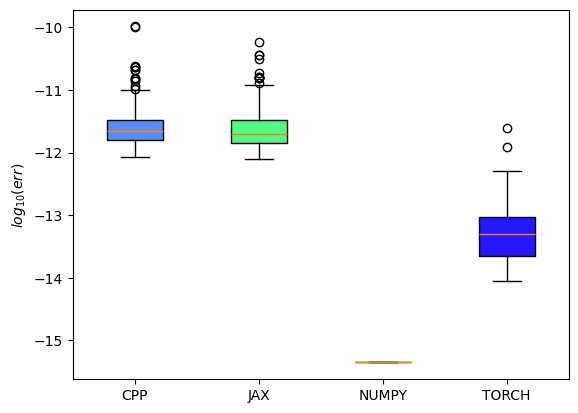

In [20]:
backend_color_map = {
    'NUMPY': '#568df5',
    'JAX': '#52fa85',
    'TORCH': '#fa6b52',
    'CPP': '#2617ff'
}

fig, ax = plt.subplots()
ax.set_ylabel('$log_{10}(err)$')

bplot = ax.boxplot(
    [np.log10(err) for err in backend_error_map.values()],
    patch_artist=True,
    tick_labels=backend_error_map.keys()
)

for patch, color in zip(bplot['boxes'], backend_color_map.values()):
    patch.set_facecolor(color)

plt.show()

The numpy implementation was the reference in this experiment, so it's normal that its absolute error is the lowest. The other implementations could have introduced errors by:
  * calling lower precision variants of trigonometric functions
  * implementing a different reduction strategy for the plus operator

The phase is uniformely distributed in $[0, 2 \pi]$ so this kind of errors don't scare me. This is primarely a test for buggy implementations.

In [13]:
# test for faulty implementations we need to be extremely precise about the:
#   * name of the implementation
#   * backend
#   * seed of the faulty experiment
#
# since I'm not expecting this section to be very much used, I'll just print the faulty rows
faulty_impls_data = df[df['abs_err'] > 1e-9]

if len(faulty_impls_data) > 0:
    print('Validation error: there are experiments with an high absolute error')
    faulty_impls_data.head()
    raise RuntimeError
else:
    print('Validation complete')


Validation complete


### Performance
The data campaign doesn't specifically test for performance as it will be very wasteful to profile a known bad implementation. From this data we can screen for the best implementation in each category, then we can inform more accurate test pipelines.

In [14]:
local = df[
    (df['algorithm'] == 'RS') &
    (df['device'] == 'CPU') &
    (df['dtype'] == 'fp64')
]

In [15]:
# I need a dictionary that pairs (backend, name) as keys
# this is because there are implementations in different backends
# with the same name
#
# I could do a dictionary of dictionaries because I don't really need
# to index by name, I need to index by backend first and then by name
backend_nested_map = {}

for backend, _df in local.groupby('backend'):
    backend_nested_map[backend] = {}

    for name, _ddf in _df.groupby('name'):
        # In the verification script, the first call to `torch.compile` is always
        # painfully slow. The correct way to proceed is to remove the incriminated
        # sample, which is hopefully only the first one
        backend_nested_map[backend][name] = _ddf['total_time'].to_numpy()[1:]

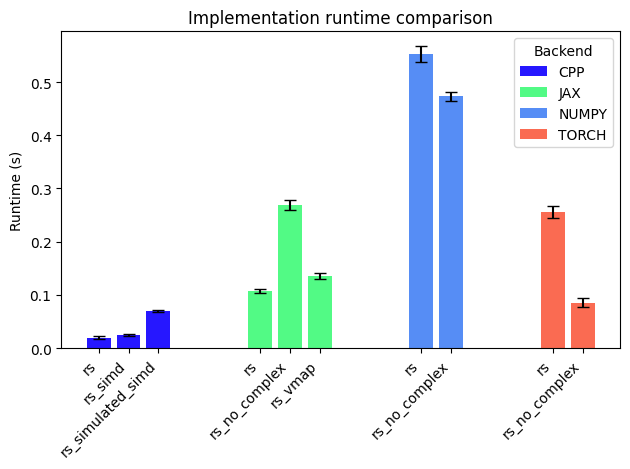

In [16]:
fig, ax = plt.subplots()

# plotting parameters, for decoration
bar_width = 0.2
intra_gap = 0.05
group_gap = 0.6

offset = 0.0
x_positions = []
x_labels = []

for backend, nested_map in backend_nested_map.items():
    for name, t in nested_map.items():
        mean = np.mean(t)
        std = np.std(t)

        ax.bar(
            offset,
            mean,
            bar_width,
            yerr=std,
            color=backend_color_map[backend],
            capsize=4,
            label=backend
        )

        x_positions.append(offset)
        x_labels.append(name)
        offset += bar_width + intra_gap

    offset += group_gap

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

ax.set_ylabel("Runtime (s)")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Backend")

plt.title('Implementation runtime comparison')
plt.tight_layout()
plt.show()

The big variability in the torch version of `rs` is due to:
  * JIT compilation
  * torch non fully supporting complex numbers operations

I think that JAX implementations could still be improved by properly setting up multicore execution.

In [17]:
# for each backend we take the best implementation
# this information will be used for directing the profiling effort
backend_best = {}

for backend in local['backend'].unique():
    all_impls_in_backend = backend_nested_map[backend]
    candidates = [
        (name, np.median(t))
        for name, t in all_impls_in_backend.items()
    ]

    best_candidate = min(candidates, key=lambda x: x[1])
    backend_best[backend] = best_candidate

backend_best

{'NUMPY': ('rs_no_complex', np.float64(0.4725657200006026)),
 'JAX': ('rs', np.float64(0.1073600219997388)),
 'TORCH': ('rs_no_complex', np.float64(0.0817540219995862)),
 'CPP': ('rs', np.float64(0.0187231780000729))}

```
{'NUMPY': ('rs_no_complex', 0.426689131000785),
 'JAX': ('rs', 0.1090442990007432),
 'TORCH': ('rs_no_complex', 0.0856768409994401),
 'CPP': ('rs', 0.0203647409998666)}
```

In [18]:
backends = []
impl_names = []
impl_runtimes = []

for backend, (name, runtime) in backend_best.items():
    backends.append(backend)
    impl_names.append(name)
    impl_runtimes.append(runtime)

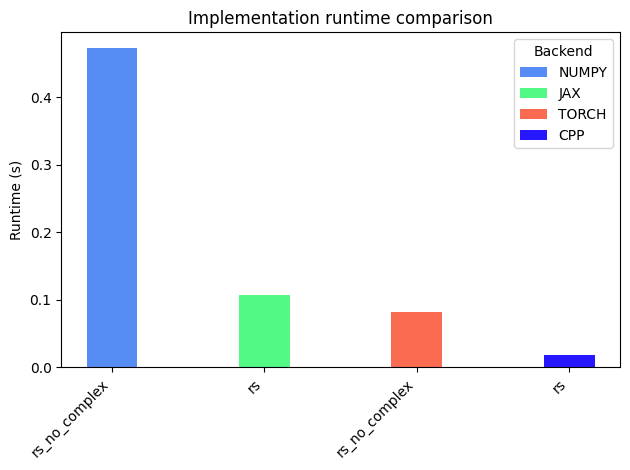

In [19]:
fig, ax = plt.subplots()

offset = 0.0
x_positions = []
x_labels = impl_names

for backend, name, runtime in zip(backends, impl_names, impl_runtimes):
    ax.bar(
        offset,
        runtime,
        bar_width,
        color=backend_color_map[backend],
        capsize=4,
        label=backend
    )

    x_positions.append(offset)

    offset += group_gap

ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

ax.set_ylabel("Runtime (s)")
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Backend")

plt.title('Implementation runtime comparison')
plt.tight_layout()
plt.show()